# Computational Research Assisstant - Afforestation

Importing the necessary libraries

In [221]:
import geopandas as gpd # To read the data and manipulate it
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shapely as shp
import pulp

Reading the data and exploring properties  

In [222]:
# Read the shapefile landparcels.shp into a GeoDataFrame
data = gpd.read_file("land_parcels")

# Exploring 
print("Coordinate system: ", data.crs) # To confirm the coordinate system of the file
print("Number of rows: ", len(data)) # To confirm the number of rows of the file
print("Column names: ", data.columns) # To confirm the column names of the file
print(data.head())

Coordinate system:  EPSG:4326
Number of rows:  100
Column names:  Index(['parcel_id', 'carbon_sto', 'cost', 'geometry'], dtype='object')
   parcel_id  carbon_sto         cost  \
0          0   57.050444  4706.178160   
1          1   28.383328  3722.863104   
2          2   31.481736  2281.036311   
3          3   70.452120  1849.986859   
4          4   38.455948  3883.390216   

                                            geometry  
0  POLYGON ((-95.0285 49.00837, -95.02067 49.0904...  
1  POLYGON ((-94.91661 48.9865, -94.9098 49.12743...  
2  POLYGON ((-94.7894 49.01419, -94.8242 49.07556...  
3  POLYGON ((-94.72478 49.02353, -94.69378 49.120...  
4  POLYGON ((-94.62821 48.99532, -94.58622 49.118...  


Research on what are coordinate systems:  
EPSG:4326 has coordinates in angular units (degrees of latitude and longitude) and are good for locating places on Earth, for making global maps, and minimizing shape distortion.  
EPSG:3347 has coordinates in linear units (meters) and are good for measuring distances.

In [223]:
newdata = data.to_crs(3347)
# print(data.geometry.area) # in meters^2
newdata['area'] = newdata.geometry.area / 1e6 # in km^2
print(newdata['area'])

0     100.449939
1      86.099804
2      63.284145
3      95.908805
4     123.674383
         ...    
95     89.530856
96     58.881358
97     96.294660
98     76.592499
99     75.373138
Name: area, Length: 100, dtype: float64


Text(0.5, 1.0, 'PLotting of ploygons')

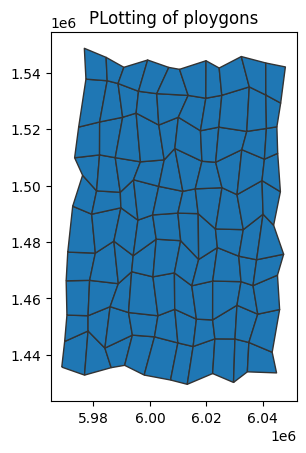

In [224]:
# Plotting the region to better understand what we are doing
newdata.plot(edgecolor="0.2")
plt.title("PLotting of ploygons")

Filtering task

Threshold:  29.86073176765897  Minimum value:  37.37824723691204


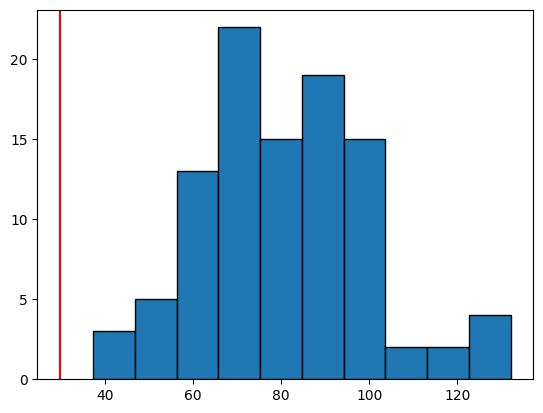

In [225]:
# Filtering area
plt.hist(newdata['area'], edgecolor="black")

# I defined outlier as outside mean - 1.5*IQR below lower quartile like in boxplots
areas = newdata['area']
IQR = areas.quantile(0.75) - areas.quantile(0.25)
threshold = areas.quantile(0.25) - 1.5 * IQR
print("Threshold: ", threshold, " Minimum value: ", areas.min())
# Since threshold < minimum, there is no outliers
plt.axvline(x=threshold, color="red")


Finding range of carbon_store

In [226]:
carbonmax = newdata['carbon_sto'].max()
carbonmin = newdata['carbon_sto'].min()
print("Max: ", carbonmax)
print("Min: ", carbonmin)
print("Range: ", carbonmax-carbonmin)

Max:  99.8608996768998
Min:  10.036534572755878
Range:  89.82436510414392


Finding range of cost

In [227]:
costmax = newdata['cost'].max()
costmin = newdata['cost'].min()
print("Max: ", costmax)
print("Min: ", costmin)
print("Range: ", costmax-costmin)

Max:  4982.434015347925
Min:  524.9516816211429
Range:  4457.482333726783


To know if they share an edge, I tried writing a helper function which outputs all the edges of a plygon.  
Then seeing if they are shared (equal to each other)

In [228]:
# Returns all the edge of a polygon as a linestring
def createdge(polygon):
    edges = []
    coords = list(polygon.exterior.coords)
    for i in range(0, 4): # All polygons are quadrilaterals
        edge = shp.LineString([coords[i], coords[(i + 1)]])
        edges.append(edge)
    return edges

adjacencydict = {}  # Contains all the edge of each parcel ID
for i,row in newdata.iterrows():
    edge = createdge(row['geometry'])
    adjacencydict[i] = edge

sharededges = {} # Contains the ID of shared parcels
for i, edges1 in adjacencydict.items():
    sharedidx = list()
    for j, edges2 in adjacencydict.items():
        for line in edges1:
            for secline in edges2:
                if (i != j and line.equals(secline)):
                    sharedidx.append(j)
    sharededges[i] = sharedidx

# Printing for interpretability 
for i,keys in sharededges.items():
    print("Idx: ", i, "shares edges with ", keys)

Idx:  0 shares edges with  [1, 10]
Idx:  1 shares edges with  [0, 2, 11]
Idx:  2 shares edges with  [1, 3, 12]
Idx:  3 shares edges with  [2, 4, 13]
Idx:  4 shares edges with  [3, 5, 14]
Idx:  5 shares edges with  [4, 6, 15]
Idx:  6 shares edges with  [5, 7, 16]
Idx:  7 shares edges with  [6, 8, 17]
Idx:  8 shares edges with  [7, 9, 18]
Idx:  9 shares edges with  [8, 19]
Idx:  10 shares edges with  [0, 11, 20]
Idx:  11 shares edges with  [1, 10, 12, 21]
Idx:  12 shares edges with  [2, 11, 13, 22]
Idx:  13 shares edges with  [3, 12, 14, 23]
Idx:  14 shares edges with  [4, 13, 15, 24]
Idx:  15 shares edges with  [5, 14, 16, 25]
Idx:  16 shares edges with  [6, 15, 17, 26]
Idx:  17 shares edges with  [7, 16, 18, 27]
Idx:  18 shares edges with  [8, 17, 19, 28]
Idx:  19 shares edges with  [9, 18, 29]
Idx:  20 shares edges with  [10, 21, 30]
Idx:  21 shares edges with  [11, 20, 22, 31]
Idx:  22 shares edges with  [12, 21, 23, 32]
Idx:  23 shares edges with  [13, 22, 24, 33]
Idx:  24 shares ed

Optimization task (Using pulp)

In [ ]:
model = pulp.LpProblem("MaximizeCarbonStore", pulp.LpMaximize)

# Decision Variables
x = np.array([f"x{i}" for i in range(100)])
decision = {idx: pulp.LpVariable(idx, cat="Binary") for idx in x}

# Objective function
objeq = 0  
for idx, name in enumerate(x):
    objeq += decision[name] * newdata["carbon_sto"].iloc[idx]
model += objeq

# Constraint 1 - Budget < 0.5 total cost
totalcost = newdata['cost'].sum()
const1 = 0  
for idx, name in enumerate(x):
    const1 += decision[name] * newdata["cost"].iloc[idx]
model += const1 <= 0.5 * totalcost

# Constraint 2 - No two polygons share edges each other
for idx, adj in sharededges.items():
    for idx2 in adj:
        name1 = "x" + str(idx)
        name2 = "x" + str(idx2)
        model += decision[name1] + decision[name2] <= 1

# Constraint 3 - Area > 0.25 total area
totalarea = newdata['area'].sum()
const3 = 0  
for idx, name in enumerate(x):
    const3 += decision[name] * newdata["area"].iloc[idx]
model += const3 >= 0.25 * totalarea

model.solve()
# Printing outputs
output = []
cost = 0
cstore = 0
for name, var in decision.items():
    if(var.varValue > 0):
        idx = int(name[1:])

        # For the ID of the parcel
        output.append(idx)
        # For total cost and cstore
        cost += newdata["cost"].iloc[idx]
        cstore += newdata["carbon_sto"].iloc[idx]

print("Chosen polygons:", output[:-2])
print("Total cost", cost)
print("Total carbon storage:", cstore)


Chosen polygons: [0, 2, 4, 6, 9, 11, 13, 15, 18, 20, 22, 26, 29, 31, 33, 35, 37, 40, 42, 44, 46, 48, 51, 53, 55, 57, 59, 60, 62, 64, 66, 68, 71, 73, 75, 77, 79, 80, 82, 84, 86, 88, 91, 93, 95]
Total cost 139711.66828591342
Total carbon storage: 2841.3958959119273


Text(0.5, 1.0, 'PLotting of ploygons')

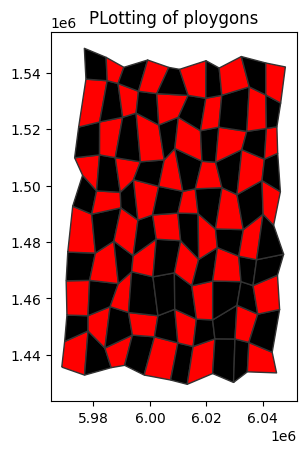

In [ ]:
# Plotting the region to better understand which polygons were chosen
colors = ["red" if i in output else "black" for i in range(100)]
newdata.plot(edgecolor="0.2", color=colors)
plt.title("Plotting of ploygons")